# ADS 509 Assignment 5.1: Topic Modeling

## Sindhu Bhattarai

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [1]:
#pip install pyLDAvis
# !pip install spacy
#!python -m spacy download en_core_web_sm 

In [2]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')


In [3]:
# add any additional libaries you need here



In [4]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [7]:
df.head(10)

,category,id,text
0,editorial,cb01,Assembly session brought much good The General...
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra..."
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...
4,editorial,cb05,Help when needed If the Dominican Republic ach...
5,editorial,cb06,The study of the St. Louis area's economic pro...
6,editorial,cb07,The U.N.'s ' gravest crisis ' Ambassador Steve...
7,editorial,cb08,"Old , tired , trembling the woman came to the ..."
8,editorial,cb09,Mr. Podger always particularly enjoyed the las...
9,editorial,cb10,"Miami , Fla. , March 17 . An out-of-town write..."


In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


In [9]:
df.head(10)

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241
5,editorial,cb06,The study of the St. Louis area's economic pro...,12777,2231
6,editorial,cb07,The U.N.'s ' gravest crisis ' Ambassador Steve...,12584,2239
7,editorial,cb08,"Old , tired , trembling the woman came to the ...",11340,2395
8,editorial,cb09,Mr. Podger always particularly enjoyed the las...,11960,2312
9,editorial,cb10,"Miami , Fla. , March 17 . An out-of-town write...",11581,2298


<AxesSubplot:xlabel='category'>

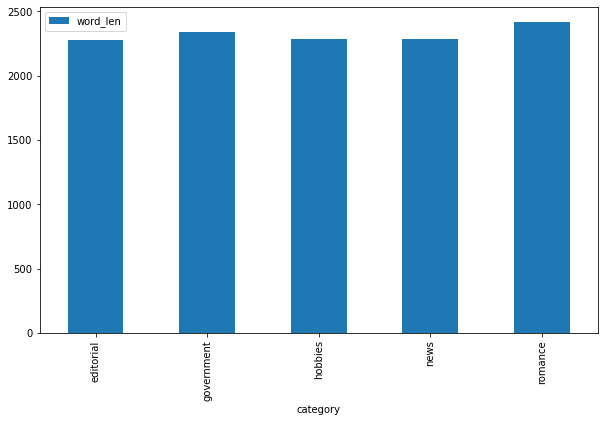

In [10]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [11]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/sakshyamdahal/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(166, 4941)

In [12]:
count_text_vectors

<166x4941 sparse matrix of type '<class 'numpy.int64'>'
	with 72541 stored elements in Compressed Sparse Row format>

In [13]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [14]:
viz_count_text_vectors= pd.DataFrame(count_text_vectors.todense())
viz_count_text_vectors.head(10)

,0,1,2,3,4,5,6,7,8,9,...,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940
0,0,3,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,3,0,0,0,1,0,1,0,0,...,0,0,0,3,0,0,0,0,2,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,0,1,0,0,0,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,9,1,0,0,0,0,0,0,1,...,0,0,0,4,0,0,1,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,1,2,0,2,0,0,2,0,1,1
7,0,2,1,0,0,0,0,0,1,1,...,0,0,0,0,5,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,1,0,0


In [15]:
viz_tfidf_text_vectors= pd.DataFrame(tfidf_text_vectors.todense())
viz_tfidf_text_vectors.head(10)

,0,1,2,3,4,5,6,7,8,9,...,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940
0,0.0,0.046852,0.000000,0.000000,0.000000,0.000000,0.0,0.023450,0.000000,0.019456,...,0.000000,0.0000,0.000000,0.016895,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.040107,0.000000,0.000000,0.000000,0.015896,0.0,0.020074,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.043389,0.000000,0.0,0.000000,0.000000,0.062348,0.000000
2,0.0,0.000000,0.000000,0.041794,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.034956,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.016735,0.000000,0.000000,0.000000,0.039797,0.0,0.000000,0.000000,0.020849,...,0.000000,0.0000,0.036429,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.014687,0.000000,0.018843,0.019635,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,0.0,0.117943,0.012624,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.016326,...,0.000000,0.0000,0.000000,0.056708,0.000000,0.0,0.026276,0.000000,0.000000,0.030558
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.024148,0.0512,0.000000,0.033436,0.000000,0.0,0.061972,0.000000,0.036035,0.036035
7,0.0,0.033729,0.016246,0.000000,0.000000,0.000000,0.0,0.000000,0.022789,0.021009,...,0.000000,0.0000,0.000000,0.000000,0.090482,0.0,0.000000,0.000000,0.000000,0.000000
8,0.0,0.000000,0.000000,0.000000,0.000000,0.017517,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.031617,0.0,0.000000,0.000000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.035609,0.017660,0.0,0.000000,0.029138,0.000000,0.000000


### Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The dataframe count_text_vectors holds each tokens as features/columns obtained from the text and data of count of those tokens from all corporas.

Similarly, another dataframe tfidf_text_vectors holds each token as features/columns but the data inside is the proportion of occurence of each token in all corporas. 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [16]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/Users/sakshyamdahal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [17]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/Users/sakshyamdahal/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [18]:
# Your code here

#results from  NMF factorization 
nmf_fact_df = pd.DataFrame(W_text_matrix)
nmf_fact_df.head(10)

,0,1,2,3,4
0,0.168337,0.000000,0.196650,0.000000,0.028598
1,0.321769,0.000000,0.000000,0.000000,0.000000
2,0.273861,0.040403,0.000000,0.000000,0.001421
3,0.270374,0.000000,0.048464,0.000000,0.000345
4,0.200523,0.002224,0.111485,0.000000,0.017609
5,0.211292,0.000000,0.088731,0.000929,0.020756
6,0.239705,0.000000,0.077159,0.000000,0.000000
7,0.043447,0.287038,0.011260,0.032032,0.000000
8,0.076158,0.130073,0.017036,0.112494,0.008497
9,0.000000,0.180889,0.068073,0.000000,0.192868


In [19]:
#comparision df
comp_df = df

#reference: https://stackoverflow.com/questions/47637696/returning-a-column-header-which-corresponds-to-a-maximum-value-in-a-row
#idxmax function to find row index at which the maximum value occurs

comp_df['topic_nmf'] = nmf_fact_df.idxmax(axis=1)
comp_df.head(10)

,category,id,text,char_len,word_len,topic_nmf
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,2
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,0
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,0
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,0
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,0
5,editorial,cb06,The study of the St. Louis area's economic pro...,12777,2231,0
6,editorial,cb07,The U.N.'s ' gravest crisis ' Ambassador Steve...,12584,2239,0
7,editorial,cb08,"Old , tired , trembling the woman came to the ...",11340,2395,1
8,editorial,cb09,Mr. Podger always particularly enjoyed the las...,11960,2312,1
9,editorial,cb10,"Miami , Fla. , March 17 . An out-of-town write...",11581,2298,4


### Comparing the NMF factorization to the original categories from the Brown Corpus

In [20]:
#original categories 

original= df['category'].value_counts() 
original

news          44
hobbies       36
government    30
romance       29
editorial     27
Name: category, dtype: int64

In [21]:
# tally the Brown categories for each topic in NMF model
tally = comp_df.groupby('topic_nmf')['category'].value_counts()
tally

topic_nmf  category  
0          editorial     20
           news           8
           government     4
1          romance       29
           hobbies        8
           editorial      4
2          government    26
           hobbies       26
           news          11
           editorial      2
3          news          17
           hobbies        1
4          news           8
           editorial      1
           hobbies        1
Name: category, dtype: int64

In [22]:
#for better vizualization 
tally_df = tally.unstack(level='category')
tally_df

category,editorial,government,hobbies,news,romance
topic_nmf,,,,,
0,20.0,4.0,NaN,8.0,NaN
1,4.0,NaN,8.0,NaN,29.0
2,2.0,26.0,26.0,11.0,NaN
3,NaN,NaN,1.0,17.0,NaN
4,1.0,NaN,1.0,8.0,NaN


<AxesSubplot:title={'center':'Categories count in each topic'}, xlabel='Topics', ylabel='Counts'>

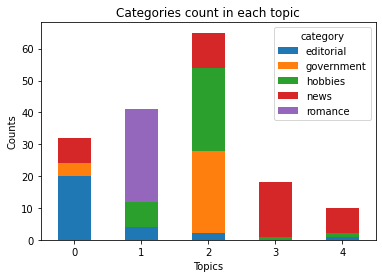

In [23]:
#bar graph for above information
tally_df.plot(kind='bar', ylabel = 'Counts', xlabel = 'Topics', title='Categories count in each topic', stacked=True,rot = 0)


### Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF model suggests:
Topic 0 incorporates 3 categories, highest editorial(20) followed by news(8) and government(4).
Topic 1 also incorporates 3 categories,highest romance(29) followed by hobbies(8) and editorial(4).
Topic 2 has incorporated most categories(4), highest government(26) and hobbies(26) followed by news(11) and editorial(2) .
Topic 3 incorporates 2 categories, highest news(17) and just 1 hobbies category .
Topic 4 incorporates 2 categories, highest news(8) followed by just 1 hobbies  category and 1 editorial category. 

Topic 2 seems to give more close representation of original Brown categories than other topics. 


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [24]:
# Your code here
svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [25]:
#results from  lsa model 
lsa_result_df = pd.DataFrame(W_svd_text_matrix)
lsa_result_df.head(10)

,0,1,2,3,4
0,0.389571,-0.249759,-0.018924,-0.055399,-0.004691
1,0.363091,-0.237164,0.205516,-0.269999,0.151907
2,0.377606,-0.138141,0.152397,-0.212976,0.092863
3,0.379242,-0.231832,0.104939,-0.172837,0.079050
4,0.359520,-0.211548,0.039073,-0.085072,0.017600
5,0.343003,-0.230441,0.069978,-0.083342,0.066663
6,0.355360,-0.241552,0.079320,-0.158233,0.035876
7,0.361969,0.203922,0.004332,-0.098157,-0.098348
8,0.325978,0.059162,0.064256,0.006680,-0.019780
9,0.336625,0.167157,-0.154820,0.031803,0.174192


In [26]:
#comparision df
comp_df['topic_lsa'] = lsa_result_df.idxmax(axis=1)
comp_df.head(10)

,category,id,text,char_len,word_len,topic_nmf,topic_lsa
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,2,0
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,0,0
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,0,0
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,0,0
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,0,0
5,editorial,cb06,The study of the St. Louis area's economic pro...,12777,2231,0,0
6,editorial,cb07,The U.N.'s ' gravest crisis ' Ambassador Steve...,12584,2239,0,0
7,editorial,cb08,"Old , tired , trembling the woman came to the ...",11340,2395,1,0
8,editorial,cb09,Mr. Podger always particularly enjoyed the las...,11960,2312,1,0
9,editorial,cb10,"Miami , Fla. , March 17 . An out-of-town write...",11581,2298,4,0


In [27]:
# tally the Brown categories for each topic in LSA model
tally_lsa = comp_df.groupby('topic_lsa')['category'].value_counts()
tally_lsa

topic_lsa  category  
0          hobbies       36
           news          34
           government    30
           editorial     27
           romance       21
1          romance        8
3          news           3
4          news           7
Name: category, dtype: int64

In [28]:
#for better vizualization 
tally_df_lsa = tally_lsa.unstack(level='category')
tally_df_lsa

category,editorial,government,hobbies,news,romance
topic_lsa,,,,,
0,27.0,30.0,36.0,34.0,21.0
1,NaN,NaN,NaN,NaN,8.0
3,NaN,NaN,NaN,3.0,NaN
4,NaN,NaN,NaN,7.0,NaN


<AxesSubplot:title={'center':'Categories count in each topic'}, xlabel='Topics', ylabel='Counts'>

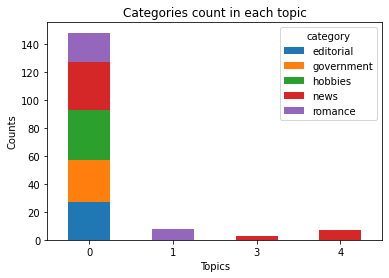

In [29]:
#bar graph for above information
tally_df_lsa.plot(kind='bar', ylabel = 'Counts', xlabel = 'Topics', title='Categories count in each topic', stacked=True,rot = 0)



### Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The topic structure generated by the LSA model is quite different from NMF. Topic 0 incorporates all the categories and other topics just gives one category. Topic 2 has no categories tally. The words like 'mr', 'mrs' and 'said' are common in topic 0 and 2 ,due to which the categories of topic 2 might have been placed in topic 0. Topic 3 and 4 seems to have only one and the same category "news". Topic 1 too has one category, romance. This model could not be relied on looking at the uneven and uninterpretable results. 



In [30]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())



Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


/Users/sakshyamdahal/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Q: What is your interpretation of the display topics output? 

A: Display topic output actually carries the key words and for different topic we have modeled. There seems to be no clear distinction between different topics in the LSA model . Topic 3 and 4 is mostly relying towards hobbies category looking at the key word but when we look at the percentage of word contribution in each topic , words mr, mrs and said are common and most prevalent in Topic 0 and 2 which makes things more unclear. 



## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [31]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [32]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())




Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


### Q: What inference do you draw from the displayed topics for your LDA model?

A: In the results of LDA model topics, there is much clearer representation of the topic than in other models.  Topic 1, topic 2 and topic 3 seems to be more relient towards news, editorial and government category.Topic 0 seems to have more reflection of hobbies category . Topic 4 looks more relient towards romance . However, I cannot see the clear representation of the editorial category through these word contributions on different topics. Editorial might reflect a little bit on each of the topics . 


In [33]:
lda_result_df = pd.DataFrame(W_lda_text_matrix)
lda_result_df

,0,1,2,3,4
0,0.000253,0.240931,0.749185,0.000252,0.009379
1,0.000249,0.000249,0.999005,0.000249,0.000249
2,0.022275,0.000284,0.888139,0.000286,0.089016
3,0.000274,0.121155,0.878023,0.000274,0.000274
4,0.013916,0.041343,0.905029,0.039454,0.000257
...,...,...,...,...,...
161,0.000234,0.999062,0.000234,0.000233,0.000237
162,0.275331,0.542643,0.143350,0.038405,0.000271
163,0.647593,0.351635,0.000257,0.000259,0.000255
164,0.970608,0.028612,0.000261,0.000261,0.000259


In [34]:
#comparision df
comp_df['topic_lda'] = lda_result_df.idxmax(axis=1)
comp_df.head(10)

,category,id,text,char_len,word_len,topic_nmf,topic_lsa,topic_lda
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,2,0,2
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,0,0,2
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,0,0,2
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,0,0,2
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,0,0,2
5,editorial,cb06,The study of the St. Louis area's economic pro...,12777,2231,0,0,2
6,editorial,cb07,The U.N.'s ' gravest crisis ' Ambassador Steve...,12584,2239,0,0,2
7,editorial,cb08,"Old , tired , trembling the woman came to the ...",11340,2395,1,0,4
8,editorial,cb09,Mr. Podger always particularly enjoyed the las...,11960,2312,1,0,2
9,editorial,cb10,"Miami , Fla. , March 17 . An out-of-town write...",11581,2298,4,0,0


In [35]:
# tally the Brown categories for each topic in LSA model
tally_lda = comp_df.groupby('topic_lda')['category'].value_counts()
tally_lda

topic_lda  category  
0          hobbies       16
           news           9
           editorial      3
1          government    20
           hobbies       14
           news           3
           editorial      1
2          news          31
           editorial     22
           government     2
           hobbies        1
3          government     8
           hobbies        3
           news           1
4          romance       29
           hobbies        2
           editorial      1
Name: category, dtype: int64

In [36]:
#for better vizualization used dataframe 
tally_df_lda = tally_lda.unstack(level='category')
tally_df_lda

category,editorial,government,hobbies,news,romance
topic_lda,,,,,
0,3.0,NaN,16.0,9.0,NaN
1,1.0,20.0,14.0,3.0,NaN
2,22.0,2.0,1.0,31.0,NaN
3,NaN,8.0,3.0,1.0,NaN
4,1.0,NaN,2.0,NaN,29.0


<AxesSubplot:title={'center':'Categories count in each topic'}, xlabel='Topics', ylabel='Counts'>

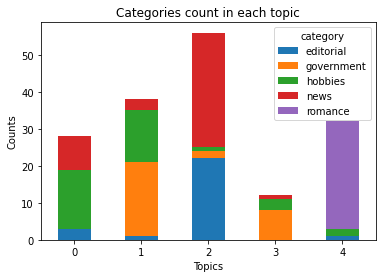

In [37]:
#bar graph for above information
tally_df_lda.plot(kind='bar', ylabel = 'Counts', xlabel = 'Topics', title='Categories count in each topic', stacked=True,rot = 0)






### Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: After tallying the original brown categories with the topics generated by the LDA model, I can see that more topics here represent different categories which are significantly relatable. The highest probability of a distinct category is much clearer in the LDA model than LSA and NMF.For example Topic 0 can be hobbies and topic 4 can be romance . Topic 1 and 2 are more relient towards government , news and editorial. 



In [38]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/Users/sakshyamdahal/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/sakshyamdahal/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [39]:
pyLDAvis.display(lda_display)

### Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A:In diffrent topic bubble we can see the word distribution in the particular topic we select. Topic 2 and 4 are overlapps, topic 4 word distribution is similar to topic 2 in heavy amount. Very less distict word in topic 4. Topic 3 has the largest bubble and holds most of the tokens(32.8%). Topiuc 3 do share some common words/tokens with topic 2. Topic 1 and topic 5 are far away from other topic and hold distict word token than other. 

Top-30 most salient terms graph represents the word frequency of the selected topic and overall word frequency. Topic 2, 3 and 5 word graph  decreasing quickly while topic 1, and 4 have gradual decrease. Topic 1,2 and 4 are not very pronounced. 

This graph is very handy while presenting the topic/word distribution and exploratory analysis.

